In [1]:
import pandas
from itertools import product
import sys, argparse, os
import numpy as np
from math import log, ceil
from scipy.stats import multinomial, chi2
from math import factorial
import re
import os

In [2]:
from Bio import Phylo
from io import BytesIO     # for handling byte strings
from io import StringIO    # for handling unicode strings

## Define Bandelt_Node Class

In [3]:
class Bandelt_Node:
    def __init__(self, data):
        self.parent = None
        self.left = None
        self.right = None
        self.data = data
        
    def find_node(self, val):
        if self.data == val:
            return self
        else:
            if (self.left == None) and (self.right == None):
                return None
            if self.left != None:
                find_left = self.left.find_node(val)
                if find_left != None:
                    return find_left
            if self.right != None:
                find_right = self.right.find_node(val)
                if find_right != None:
                    return find_right
            return None
        
    def print_details(self):
        parent_data = self.parent.data if (self.parent != None) else self.parent
        left_data = self.left.data if (self.left != None) else self.left
        right_data = self.right.data if (self.right != None) else self.right
        print("Current Value: ", self.data, "; Parent: ", parent_data, "; left: ", left_data, "; right: ", right_data)
        
    def print_subtree(self, indent_num = 1):
        if indent_num == 1:
            print(self.data)
        if self.left != None:
            print('___'*indent_num, self.left.data)
            self.left.print_subtree(indent_num + 1)
        if self.right != None:
            print('___'*indent_num, self.right.data)
            self.right.print_subtree(indent_num + 1)
            
    def compare_subtree(self, compared_root_node):
        if self.data != compared_root_node.data:
#             print("Current number is not equal!")
            return False
        
        self_left_data = self.left.data if (self.left != None) else None
        self_right_data = self.right.data if (self.right != None) else None

        compared_root_node_left_data = compared_root_node.left.data if (compared_root_node.left != None) else None
        compared_root_node_right_data = compared_root_node.right.data if (compared_root_node.right != None) else None

        
        if (self_left_data in [compared_root_node_left_data, compared_root_node_right_data]) and (self_right_data in [compared_root_node_left_data, compared_root_node_right_data]):
#             print("Children are same !!")
            if (self_left_data == compared_root_node_left_data):
#                 print("Order are same !!")
                if self.left != None:
                    compare_ans_left = self.left.compare_subtree(compared_root_node.left)
                    if not compare_ans_left:
                        return False
                if self.right != None:
                    compare_ans_right = self.right.compare_subtree(compared_root_node.right)
                    if not compare_ans_right:
                        return False
                
            elif (self_left_data == compared_root_node_right_data):
#                 print("Order are not same !!")
                if self.left != None:
                    compare_ans_left = self.left.compare_subtree(compared_root_node.right)
                    if not compare_ans_left:
                        return False
                if self.right != None:
                    compare_ans_right = self.right.compare_subtree(compared_root_node.left)
                    if not compare_ans_right:
                        return False
        else:
#             print("Children are not same !!")
            return False
        return True

## Read files and get name mapping dictionary

In [4]:
folder_list = ['Bergsten_2013']

In [5]:
training_dataset_prefix = "../training_small"

In [6]:
dic={'A':'1', 'T':'2', 'C':'3', 'G':'4', '-':'0', '?':'0'}

In [7]:
mapping_dic_dic = {}

In [8]:
BRANCH_NUM = 100
SEQUENCE_LEN = 1000

In [9]:
# data preprocessing
for folder in folder_list:
    file_path = os.path.join(training_dataset_prefix, folder)
    files_list = os.listdir(file_path)
    for file in files_list:
        if file.find('.nex.treefile.dist') > 0:
            file_base_name = file[0:file.find('.nex.treefile.dist')]
            #######################
            # Input Processing !! #
            #######################
            print("****: ", file_base_name+'.nex')
            seq_data_raw = open(os.path.join(file_path, file_base_name+'.nex'))
            seq_data = seq_data_raw.readlines()[6:]
            species_mapping_dic = {}
            for idx, line in enumerate(seq_data):
                curr_line = line.split()
                if len(curr_line) < 2:
                    break
#                 print(curr_line[0])
                if int(idx) == 0:
                    species_mapping_dic[curr_line[0]] = sys.maxsize
                else: 
                    species_mapping_dic[curr_line[0]] = int(idx-1)
        mapping_dic_dic[file_base_name+'.nex'] = species_mapping_dic

****:  alignment_H3_3rdpos-out.nex
****:  alignment_H3_2ndpos-out.nex
****:  alignment_COI_2ndpos-out.nex
****:  alignment_COI_3rdpos-out.nex
****:  alignment_H3_1stpos-out.nex
****:  alignment_COI_1stpos-out.nex
****:  alignment_18S-out.nex
****:  alignment_16S-out.nex


## Run all tree examples

In [10]:
# for folder in folder_list:
#     file_path = os.path.join(training_dataset_prefix, folder)
#     files_list = os.listdir(file_path)
#     for file in files_list:
#         if file.find('.nex.treefile.dist') > 0:
#             file_base_name = file[0:file.find('.nex.treefile.dist')]
#             #######################
#             # Input Processing !! #
#             #######################
#             print("****: ", file_base_name+'.nex.treefile')
#             seq_data_raw = open(os.path.join(file_path, file_base_name+'.nex.treefile'))
#             seq_data = seq_data_raw.readline()
            

## Run one dictionary example

In [11]:
tree = Phylo.read(os.path.join(file_path, 'alignment_H3_3rdpos-out.nex.treefile'), 'newick')

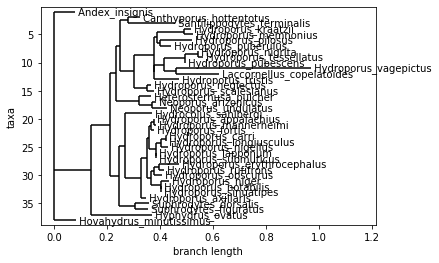

In [12]:
Phylo.draw(tree)

In [13]:
tree.root[0]

Clade(branch_length=0.0815684251, name='Andex_insignis')

In [14]:
tree.is_bifurcating()

True

In [15]:
len(tree.clade)

3

In [16]:
mapping_dic_dic['alignment_18S-out.nex']

{'Andex_insignis': 9223372036854775807,
 'Canthyporus_hottentotus': 0,
 'Heterosternusa_pulcher': 1,
 'Hovahydrus_minutissimus': 2,
 'Hydrocolus_sahlbergi': 3,
 'Hydroporus_appalachius': 4,
 'Hydroporus_axillaris': 5,
 'Hydroporus_carri': 6,
 'Hydroporus_erythrocephalus': 7,
 'Hydroporus_fortis': 8,
 'Hydroporus_kraatzii': 9,
 'Hydroporus_lapponum': 10,
 'Hydroporus_longiusculus': 11,
 'Hydroporus_mannerheimi': 12,
 'Hydroporus_memnonius': 13,
 'Hydroporus_neglectus': 14,
 'Hydroporus_nigellus': 15,
 'Hydroporus_niger': 16,
 'Hydroporus_nigrita': 17,
 'Hydroporus_notabilis': 18,
 'Hydroporus_obscurus': 19,
 'Hydroporus_pilosus': 20,
 'Hydroporus_puberulus': 21,
 'Hydroporus_pubescens': 22,
 'Hydroporus_rufifrons': 23,
 'Hydroporus_scalesianus': 24,
 'Hydroporus_sinuatipes': 25,
 'Hydroporus_submuticus': 26,
 'Hydroporus_tessellatus': 27,
 'Hydroporus_tristis': 28,
 'Hydroporus_vagepictus': 29,
 'Hyphydrus_ovatus': 30,
 'Laccornellus_copelatoides': 31,
 'Neoporus_arizonicus': 32,
 'Neop

# Implement Encoding Method

In [17]:
def create_Bandelt_Tree(clade, parent_node, file_name):
    for idx in range(len(clade)):
        if idx == 0:
            if clade[idx].is_terminal():
                children_node = Bandelt_Node(int(mapping_dic_dic[file_name+'.nex'][clade[idx].name]))
#                 # Parent add 
                parent_node.left = children_node
                children_node.parent = parent_node
#                 print(clade[idx].name)
            else:
                children_node = Bandelt_Node(int(-100))
                parent_node.left = children_node
                children_node.parent = parent_node
#                 print(clade[idx])
        if idx == 1:  
            if clade[idx].is_terminal():
                children_node = Bandelt_Node(int(mapping_dic_dic[file_name+'.nex'][clade[idx].name]))
#                 # Parent add 
                parent_node.right = children_node
                children_node.parent = parent_node
#                 print(clade[idx].name)
            else:
                children_node = Bandelt_Node(int(-100))
                parent_node.right = children_node
                children_node.parent = parent_node
#                 print(clade[idx])
        create_Bandelt_Tree(clade[idx], children_node, file_name)

In [18]:
def find_Bandelt_encode(target_node, val):
    visited_nodes = []
    queue = []
    visited_nodes.append(target_node.data)
    queue.append(target_node)
    encode_num = None
    while queue:
        current_node = queue.pop(0)
        if current_node != None:
#             print ("**** current_node: ", current_node.data) 
            if current_node.data != '*' and abs(int(current_node.data)) < abs(int(val)):
                encode_num = current_node.data
        if current_node.left != None:
            if current_node.left.data not in visited_nodes:
                visited_nodes.append(current_node.left.data)
                queue.append(current_node.left)
                
        if current_node.right != None:
            if current_node.right.data not in visited_nodes:
                visited_nodes.append(current_node.right.data)
                queue.append(current_node.right)   
        if encode_num != None:
            break
    return encode_num

In [19]:
def inner_node_indexation(current_node):
#     print(current_node.data)
    if current_node.left != None:
        left_data = inner_node_indexation(current_node.left)
    if current_node.right != None:
        right_data = inner_node_indexation(current_node.right)
    
    if current_node.left != None and current_node.right != None:
        # This is the inner node
        if len(left_data) == 0:
            current_node.data = int(-right_data[0])
            return []
        if len(right_data) == 0:
            current_node.data = int(-left_data[0])
            return []
        if len(left_data) != 0 and len(right_data) != 0:
            if abs(left_data[0]) > abs(right_data[0]):
                current_node.data = int(-left_data[0])
                return [right_data[0]]
            elif abs(left_data[0]) < abs(right_data[0]):
                current_node.data = int(-right_data[0])
                return [left_data[0]]
    elif current_node.left != None and current_node.right == None:
        print("Finish!")
    else:
        # This is the terminal node
        return [current_node.data]
#     if current_node.left == None and current_node.right == None:     
# #         # This node is the terminal vertex
#         return str(current_node.data)

#     if current_node.left != None and current_node.right != None:
#         newick_string = '(' + left_newick_string + ',' + right_newick_string + ')' + str(current_node.data)

In [23]:
tree.root[2]

Clade(branch_length=0.0852594043, name='Hovahydrus_minutissimus')

In [24]:
def Bandelt_Encode(file_name):
    tree = Phylo.read(os.path.join(file_path, file_name+'.nex.treefile'), 'newick')
    Phylo.draw(tree)
    
    # This is the root
    root_node = Bandelt_Node(sys.maxsize)
    print(tree.root[0].name)
    inner_root = Bandelt_Node(-100)
    
    if tree.root[1].is_terminal():
        left_node = Bandelt_Node(int(mapping_dic_dic[file_name+'.nex'][tree.root[1].name]))
        inner_root.left = left_node
        left_node.parent = inner_root
#                 print(clade[idx].name)
    else:
        left_node = Bandelt_Node(int(-100))
        inner_root.left = left_node
        left_node.parent = inner_root
#                 print(clade[idx])

    if tree.root[2].is_terminal():
        right_node = Bandelt_Node(int(mapping_dic_dic[file_name+'.nex'][tree.root[2].name]))
        inner_root.right = right_node
        right_node.parent = inner_root
#                 print(clade[idx].name)
    else:
        right_node = Bandelt_Node(int(-100))
        inner_root.right = right_node
        right_node.parent = inner_root
        
    # Add linkage for the first three node
    root_node.left = inner_root
    inner_root.parent = root_node
    
    create_Bandelt_Tree(tree.root[1], left_node, file_name)
    create_Bandelt_Tree(tree.root[2], right_node, file_name)
    
    inner_node_indexation(root_node)
    
    encode_num_list = []
    for i in range(0, tree.count_terminals()-2):
        target_node_val = -(i+1)
        found_node = root_node.find_node(target_node_val)
#         print(found_node.print_details(), '\n')
        encode_num = find_Bandelt_encode(found_node, target_node_val)
        encode_num_list.append(encode_num)
    return (root_node, encode_num_list)

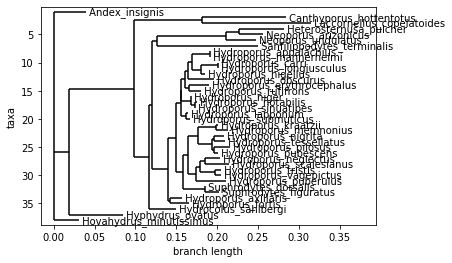

Andex_insignis
Finish!


In [25]:
encode_tree, bandelt_encode_num = Bandelt_Encode('alignment_16S-out')

In [26]:
encode_tree.print_subtree()

9223372036854775807
___ -2
______ -30
_________ -1
____________ -31
_______________ 0
_______________ 31
____________ -3
_______________ -4
__________________ -34
_____________________ -33
________________________ -32
___________________________ 1
___________________________ 32
________________________ 33
_____________________ 34
__________________ -5
_____________________ -9
________________________ -10
___________________________ -16
______________________________ -7
_________________________________ -19
____________________________________ -6
_______________________________________ -12
__________________________________________ 4
__________________________________________ 12
_______________________________________ -15
__________________________________________ -11
_____________________________________________ 6
_____________________________________________ 11
__________________________________________ 15
____________________________________ 19
_________________________________ -23
_

In [27]:
bandelt_encode_num

[0,
 -1,
 1,
 1,
 4,
 4,
 -6,
 5,
 -7,
 -7,
 6,
 4,
 9,
 -13,
 -11,
 -7,
 -13,
 16,
 -6,
 17,
 14,
 20,
 7,
 14,
 18,
 10,
 17,
 -24,
 28,
 -1,
 0,
 1,
 -32,
 -33,
 -14,
 35]

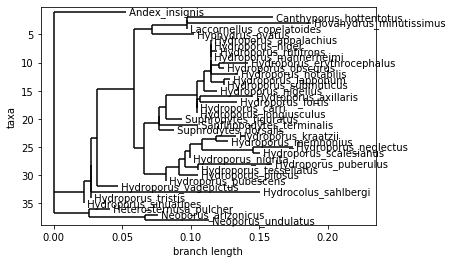

Andex_insignis
Finish!


In [35]:
encode_tree_2, bandelt_encode_num_2 = Bandelt_Encode('alignment_COI_1stpos-out')

In [36]:
encode_tree_2.print_subtree()

9223372036854775807
___ -1
______ -25
_________ -28
____________ -3
_______________ -29
__________________ -4
_____________________ -30
________________________ -31
___________________________ -2
______________________________ 0
______________________________ 2
___________________________ 31
________________________ 30
_____________________ -9
________________________ -35
___________________________ -34
______________________________ -36
_________________________________ -5
____________________________________ -15
_______________________________________ -10
__________________________________________ -7
_____________________________________________ -12
________________________________________________ -16
___________________________________________________ 4
___________________________________________________ -23
______________________________________________________ 16
______________________________________________________ 23
________________________________________________ 12
_________

In [37]:
bandelt_encode_num_2

[0,
 0,
 -2,
 -2,
 4,
 5,
 4,
 5,
 -5,
 -7,
 -6,
 4,
 9,
 -13,
 -10,
 4,
 -14,
 7,
 7,
 -17,
 -17,
 -20,
 16,
 14,
 -3,
 10,
 21,
 -3,
 -4,
 -2,
 -2,
 1,
 32,
 -5,
 -34,
 -5]

# Implement Decoding Method

In [38]:
def post_order_traversal_newick_string(current_node):
#     print(current_node.data)
    if current_node.left != None:
        left_newick_string = post_order_traversal_newick_string(current_node.left)
    if current_node.right != None:
        right_newick_string = post_order_traversal_newick_string(current_node.right)

    if current_node.left == None and current_node.right == None:     
#         # This node is the terminal vertex
        return str(current_node.data)

    if current_node.left != None and current_node.right != None:
        newick_string = '(' + left_newick_string + ',' + right_newick_string + ')' + str(current_node.data)
    return newick_string

In [39]:
def Bandelt_Decode(Bandelt_Encode_list):
    BANDELT_NUM = len(Bandelt_Encode_list)
    # Initial with three nodes
    root_node = Bandelt_Node(sys.maxsize)
    node_1 = Bandelt_Node(1)
    node_neg_1 = Bandelt_Node(-1)
    node_0 = Bandelt_Node(0)
    # Create links between initial three nodes
    root_node.left = node_neg_1
    node_neg_1.parent = root_node
    node_neg_1.left = node_0
    node_neg_1.right = node_1
    node_1.parent = node_neg_1
    node_0.parent = node_neg_1
    
    for i in range(1, BANDELT_NUM):
        added_node_val = -(i+1)
#         print('Node going to be added: ', added_node_val)
#         print('Need to find: ', Bandelt_Encode_list[i], ' node')

        added_node_neg = Bandelt_Node(added_node_val)
        added_node_pos = Bandelt_Node(-added_node_val)

        target_node = root_node.find_node(Bandelt_Encode_list[i])

        # If target node is the left child 
        if target_node.parent.left == target_node:
            target_node.parent.left = added_node_neg
            added_node_neg.parent = target_node.parent
            added_node_neg.left = target_node
            target_node.parent = added_node_neg

            added_node_neg.right = added_node_pos
            added_node_pos.parent = added_node_neg

        # If target node is the right child
        if target_node.parent.right == target_node:
            target_node.parent.right = added_node_neg
            added_node_neg.parent = target_node.parent
            added_node_neg.right = target_node
            target_node.parent = added_node_neg

            added_node_neg.left = added_node_pos
            added_node_pos.parent = added_node_neg
    decode_tree = post_order_traversal_newick_string(root_node.left)
    decode_tree_newick = decode_tree + ';'
    return (root_node, decode_tree_newick)

In [40]:
bandelt_encode_num

[0,
 -1,
 1,
 1,
 4,
 4,
 -6,
 5,
 -7,
 -7,
 6,
 4,
 9,
 -13,
 -11,
 -7,
 -13,
 16,
 -6,
 17,
 14,
 20,
 7,
 14,
 18,
 10,
 17,
 -24,
 28,
 -1,
 0,
 1,
 -32,
 -33,
 -14,
 35]

In [41]:
decode_tree, bandelt_decode_num = Bandelt_Decode(bandelt_encode_num)

In [42]:
decode_tree.print_subtree()

9223372036854775807
___ -2
______ -30
_________ -1
____________ -31
_______________ 0
_______________ 31
____________ -3
_______________ 3
_______________ -4
__________________ -5
_____________________ -9
________________________ -10
___________________________ -16
______________________________ -7
_________________________________ -19
____________________________________ -6
_______________________________________ -12
__________________________________________ 4
__________________________________________ 12
_______________________________________ -15
__________________________________________ 15
__________________________________________ -11
_____________________________________________ 11
_____________________________________________ 6
____________________________________ 19
_________________________________ -23
____________________________________ 23
____________________________________ 7
______________________________ -18
_________________________________ -25
_______________________

In [43]:
decode_tree.compare_subtree(encode_tree)

True

In [48]:
decode_tree_2, bandelt_decode_num_2 = Bandelt_Decode(bandelt_encode_num_2)

In [49]:
decode_tree_2.print_subtree()

9223372036854775807
___ -1
______ -25
_________ -28
____________ -3
_______________ -29
__________________ -4
_____________________ -30
________________________ -31
___________________________ -2
______________________________ 0
______________________________ 2
___________________________ 31
________________________ 30
_____________________ -9
________________________ -22
___________________________ -20
______________________________ -21
_________________________________ -17
____________________________________ -14
_______________________________________ -13
__________________________________________ 9
__________________________________________ 13
_______________________________________ -24
__________________________________________ 24
__________________________________________ 14
____________________________________ 17
_________________________________ -27
____________________________________ 27
____________________________________ 21
______________________________ 20
________________

In [53]:
decode_tree_2.compare_subtree(encode_tree_2)

True